# Auditing electronic voting

The goal is to construct a confidence interval for the proportion of people voting for each candidate using a small number of hand-labeled ballots and a large number of ballots read with an optical scanner. On Election Day in the United States, most voters use electronic or optical-scan ballots, neither of which is perfectly accurate. The data is taken from a special election in San Francisco for the Assembly District 17 seat on April 19, 2022. The candidates were David Campos and Matt Haney. This is an example of a risk-limiting audit: a statistically valid way to check the results of an election by inspecting subsets of ballots (see, e.g., (1)).

1. M. Lindeman and P. B. Stark, A gentle introduction to risk-limiting audits. IEEE Security & Privacy 10(5), 42–49 (2012).

### Import necessary packages

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the ballots data set

Load the data. The data set contains a small number of hand-labeled votes (```Y```), corresponding predicted votes based on computer vision (```Yhat```), and predicted votes for the remaining ballots (```Yhat_unlabeled```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Specify the ground-truth value of the estimand (reported election outcome).

In [3]:
alpha = 0.05
n_max = Y.shape[0]  # Total number of labeled ballots
ns = np.linspace(100, n_max, 20).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 500

# Reported result (official outcome)
reported_estimate = 0.6237

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_max)
        _Yhat = Yhat[rand_idx[:n]]
        _Y = Y[rand_idx[:n]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_mean_ci(Yhat_unlabeled, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0],
                "upper": imputed_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

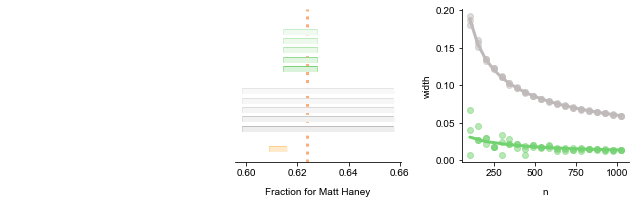

In [5]:
make_plots(
    df,
    "./plots/ballots.pdf",
    intervals_xlabel="Fraction for Matt Haney",
    true_theta=reported_estimate,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \text{fraction for Matt Haney} \leq 50\%$.

In [6]:
# Find n such that we reject H0: fraction for Matt Haney < 0.5 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [np.random.permutation(n_max) for i in range(num_experiments)]

alpha_pval = 0.05


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat[rand_idx[:n]]
        _Y = Y[rand_idx[:n]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, Yhat_unlabeled, alpha=alpha_pval)
        if ppi_ci[0] > 0.5:
            nulls_rejected += 1
        print(ppi_ci)
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y[rand_idx[:n]]

        classical_ci = classical_mean_ci(_Y, alpha=alpha_pval)

        if classical_ci[0] > 0.5:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
# n_ppi = int(brentq(_to_invert_ppi, 1, 1000, xtol=1)) # This rejects for any value n. Try it!
n_classical = int(brentq(_to_invert_classical, 1, 1000, xtol=1))
print(f"The PPI test requires n={1} labeled data points to reject the null.")
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=1 labeled data points to reject the null.
The classical test requires n=105 labeled data points to reject the null.
